In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import pandas as pd
import sunpy
import sunpy.map
from sunpy.coordinates import (get_earth, get_horizons_coord,
                                Helioprojective, propagate_with_solar_surface)
import sunkit_image
import sunkit_image.coalignment as coalignment
import astropy
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
import astropy.time
from ndcube import NDCube
from ndcube.extra_coords import (SkyCoordTableCoordinate, TimeTableCoordinate,
                                 QuantityTableCoordinate)
from scipy.interpolate import interp1d

import cmcrameri.cm as cmcm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (AutoLocator, AutoMinorLocator, 
    FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter)
from ipywidgets import interactive, widgets
from IPython.display import display, clear_output
from astropy.visualization import (AsinhStretch, LinearStretch,
        LogStretch, ImageNormalize)
import os
from sun_blinker import SunBlinker
from copy import deepcopy   
from glob import glob
import h5py

In [2]:
eui_files = sorted(glob("../../src/EUI/HRI/euv174/20221024/solo_L2_eui-hri*.fits"))
eui_map_seq = sunpy.map.Map(eui_files[:],sequence=True,memmap=True)

In [3]:
Txshift_hri, Tyshift_hri = (1.67083 + 1.40322)*u.arcsec,(7.60192 - 2.32321 )*u.arcsec

In [4]:
with h5py.File("../../src/EUI/HRI/euv174/20221024/coalign_shifts.h5","r") as f:
    eui_map_seq_coalign_shifts_x = f["x"][()]
    eui_map_seq_coalign_shifts_y = f["y"][()]
eui_map_seq_coalign_shifts = {"x":eui_map_seq_coalign_shifts_x*u.arcsec + Txshift_hri,"y":eui_map_seq_coalign_shifts_y*u.arcsec + Tyshift_hri}

In [5]:
eui_map_seq_coalign = coalignment.mapsequence_coalign_by_match_template(eui_map_seq,shift=eui_map_seq_coalign_shifts)

In [6]:
eis_195_velmap_derot_repro_hrifov = sunpy.map.Map("../../src/EIS/DHB_007_v2/20221025T0023/sunpymaps/eis_195_velmap_derot_repro_hrifov.fits")

In [114]:
eis_hhflare_195_velmap_derot_repro_hrifov = sunpy.map.Map("../../src/coalign_map/20221024/eis_hhflare_195_velmap_derot_repro_hrifov.fits")

In [7]:
eui_map_0_shift = eui_map_seq_coalign[0]

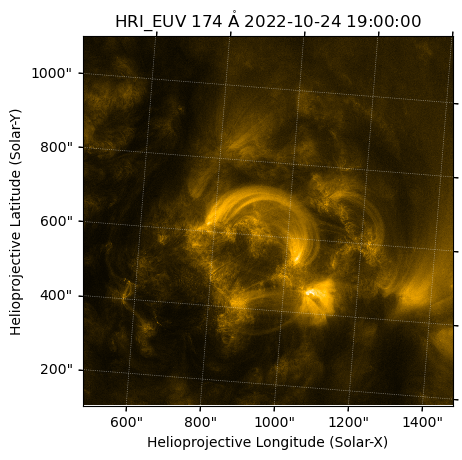

In [76]:
eui_map_0_shift.plot()

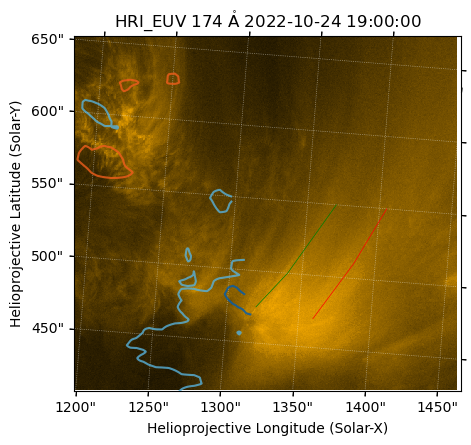

In [85]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111,projection=eui_map_0_shift)
eui_map_0_shift.plot_settings['norm'] = ImageNormalize(stretch=AsinhStretch(0.1))
eui_map_0_shift.plot(axes=ax)

bounds = ax.axis()
eis_195_velmap_derot_repro_hrifov.draw_contours(levels=[-10,-5,5,10],colors=["#005CAF","#58B2DC","#F05E1C","#E83015"],alpha=0.8,
                                                                   axes=ax)
ax.set_xlim(1500,2046)
ax.set_ylim(500,1000)

slit_1_coords = SkyCoord([1320,1340,1370]*u.arcsec,
                         [475,500,550]*u.arcsec,
                         frame=eui_map_0_shift.coordinate_frame)

slit_2_coords = SkyCoord([1360,1385,1405]*u.arcsec,
                            [470,510,550]*u.arcsec,
                            frame=eui_map_0_shift.coordinate_frame)

ax.plot_coord(slit_1_coords, color="green", lw=0.5, ls="-")
ax.plot_coord(slit_2_coords, color="red", lw=0.5, ls="-")

In [133]:
def get_intensity_spacetime_cut(slit_coords,map_seq):
    pixels_0 = sunpy.map.pixelate_coord_path(map_seq[0],slit_coords)
    pixels_0_distance = pixels_0.separation(pixels_0[0])

    intensity = []
    for map_ in map_seq:
        pixels_ = sunpy.map.pixelate_coord_path(map_,slit_coords)
        pixels_distance_ = pixels_.separation(pixels_[0])
        intensity_ = sunpy.map.sample_at_coords(map_,pixels_)
        intensity_interp_func_ = interp1d(pixels_distance_.to_value("arcsec"),intensity_.value,kind="linear",fill_value="extrapolate")
        intensity.append(intensity_interp_func_(pixels_0_distance.to_value("arcsec"))*intensity_.unit)
    
    return pixels_0, u.Quantity(intensity)

In [134]:
slit_1_pixels_0, slit_1_intensity = get_intensity_spacetime_cut(slit_1_coords,eui_map_seq_coalign)

In [135]:
slit_1_spacetime_wcs = (SkyCoordTableCoordinate(slit_1_pixels_0,
                                                physical_types=("custom:pos.helioprojective.lon","custom:pos.helioprojective.lat"),) &
                        TimeTableCoordinate(astropy.time.Time([map_.date for map_ in eui_map_seq_coalign]),
                                            physical_types="time",names="time")).wcs

In [136]:
slit_1_spacetime_cube = NDCube(slit_1_intensity,slit_1_spacetime_wcs)

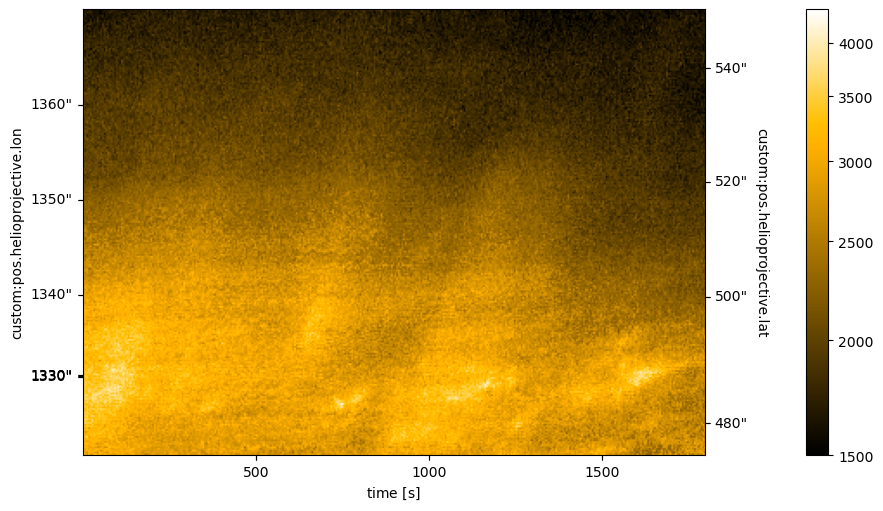

In [137]:
fig = plt.figure(figsize=(10,5),constrained_layout=True)
slit_1_spacetime_cube.plot(plot_axes=('x','y'),cmap='solar orbiterhri_euv174',norm=ImageNormalize(vmin=1500,stretch=AsinhStretch(0.4)))
plt.colorbar()

In [138]:
slit_2_pixels_0, slit_2_intensity = get_intensity_spacetime_cut(slit_2_coords,eui_map_seq_coalign)

In [139]:
slit_2_spacetime_wcs = (SkyCoordTableCoordinate(slit_2_pixels_0,
                                                physical_types=("custom:pos.helioprojective.lon","custom:pos.helioprojective.lat"),) &
                        TimeTableCoordinate(astropy.time.Time([map_.date for map_ in eui_map_seq_coalign]),
                                            physical_types="time",names="time")).wcs
slit_2_spacetime_cube = NDCube(slit_2_intensity,slit_2_spacetime_wcs)

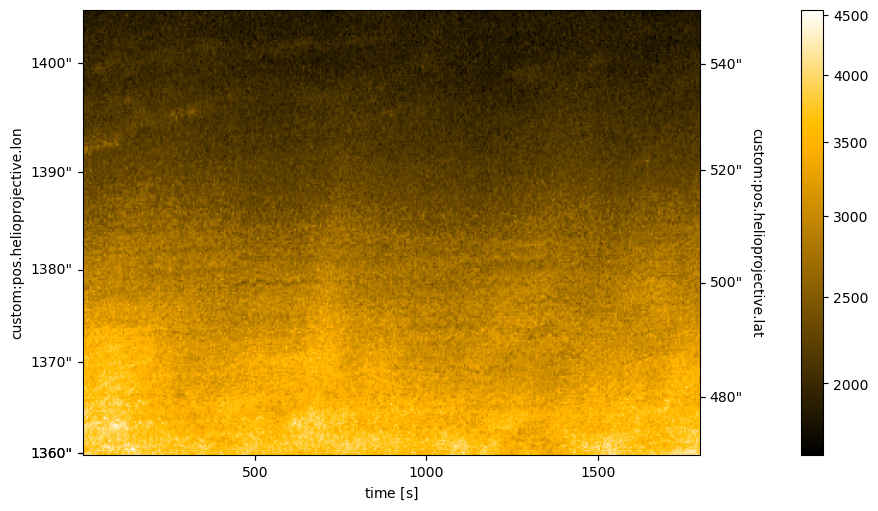

In [140]:
fig = plt.figure(figsize=(10,5),constrained_layout=True)
slit_2_spacetime_cube.plot(plot_axes=('x','y'),cmap='solar orbiterhri_euv174',norm=ImageNormalize(vmin=1600,stretch=AsinhStretch(0.8)))
plt.colorbar()

In [161]:
slit_1_pixels_0_3d = slit_1_pixels_0.make_3d()
slit_1_pixels_0_distance = []
for ii, pixel_ in enumerate(slit_1_pixels_0_3d):
    if ii == 0:
        slit_1_pixels_0_distance.append(0*u.m)
    else:
        slit_1_pixels_0_distance.append(pixel_.separation_3d(slit_1_pixels_0_3d[ii - 1]) + slit_1_pixels_0_distance[ii - 1])
slit_1_pixels_0_distance = u.Quantity(slit_1_pixels_0_distance)

In [162]:
slit_1_pixels_0_distance

<Quantity [       0.        ,   141155.85734119,   308830.46045919,
             449993.80344419,   617699.13745019,   758869.98108444,
             926606.07906559,  1067784.43822709,  1235551.33560323,
            1376737.22501681,  1544534.95497764,  1685728.38964893,
            1853556.98671964,  1994757.98175034,  2162617.47997482,
            2303826.04998552,  2471716.48501863,  2612932.64525209,
            2780854.05025364,  2922077.81538213,  3090030.22534062,
            3231261.61072578,  3399245.06044006,  3540484.08122322,
            3708498.60401326,  3849745.27493231,  4017790.90720731,
            4159045.24351944,  4327122.01923058,  4468384.03580627,
            4609652.69848011,  4777763.22146572,  4919039.59153349,
            5087181.33441349,  5228465.42741131,  5396638.42484493,
            5537930.2555475 ,  5706134.54324381,  5847434.12704937,
            6015669.73921534,  6156977.09170594,  6325244.06288421,
            6466559.19900112,  6634857.56456586,

In [164]:
slit_1_spacetime_distance_wcs = (QuantityTableCoordinate(slit_1_pixels_0_distance.to(u.Mm),
                                                physical_types="length",names="distance") &
                        TimeTableCoordinate(astropy.time.Time([map_.date for map_ in eui_map_seq_coalign]),
                                            physical_types="time",names="time")).wcs

In [165]:
slit_1_spacetime_distance_cube = NDCube(slit_1_intensity,slit_1_spacetime_distance_wcs)

0.1 Mm / s


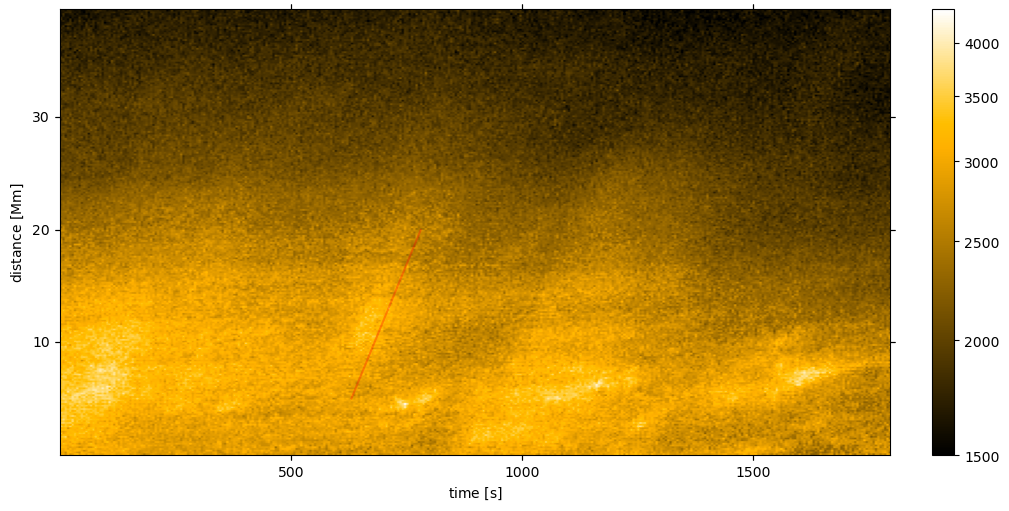

In [172]:
# this is the projected velocity 
fig = plt.figure(figsize=(10,5),constrained_layout=True)
ax = fig.add_subplot(111,projection=slit_1_spacetime_distance_cube.wcs)
slit_1_spacetime_distance_cube.plot(axes = ax, plot_axes=('x','y'),cmap='solar orbiterhri_euv174',norm=ImageNormalize(vmin=1500,stretch=AsinhStretch(0.4)),
                                    aspect="auto")

plt.colorbar()

slit_1_spacetime_distance_slope_1_x = [630,780]*u.s
slit_1_spacetime_distance_slope_1_y = [5,20]*u.Mm
slit_1_spacetime_distance_slope_1_vel = (slit_1_spacetime_distance_slope_1_y[1] - slit_1_spacetime_distance_slope_1_y[0])/ \
    (slit_1_spacetime_distance_slope_1_x[1] - slit_1_spacetime_distance_slope_1_x[0])
slit_1_spacetime_distance_slope_1_x_pixel = slit_1_spacetime_distance_cube.wcs.world_to_pixel(slit_1_spacetime_distance_slope_1_y,slit_1_spacetime_distance_slope_1_x)
ax.plot_coord(slit_1_spacetime_distance_slope_1_x_pixel[1],slit_1_spacetime_distance_slope_1_x_pixel[0],color="red",alpha=0.3,)
print(slit_1_spacetime_distance_slope_1_vel)

# ax.set_xlim(100,200)

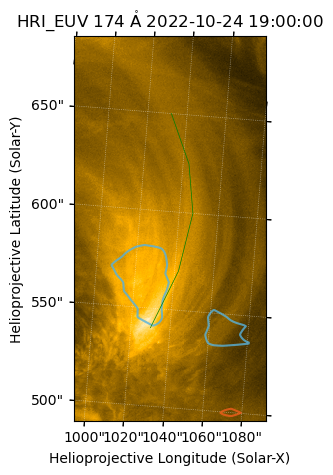

In [167]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111,projection=eui_map_0_shift)
eui_map_0_shift.plot_settings['norm'] = ImageNormalize(stretch=AsinhStretch(0.1))
eui_map_0_shift.plot(axes=ax)

bounds = ax.axis()
eis_hhflare_195_velmap_derot_repro_hrifov.draw_contours(levels=[-10,-5,5,10],colors=["#005CAF","#58B2DC","#F05E1C","#E83015"],alpha=0.8,
                                                                   axes=ax)
ax.set_xlim(1100,1300)
ax.set_ylim(700,1100)

slit_3_coords = SkyCoord([1030,1042,1047,1043,1032]*u.arcsec,
                         [540,570,600,625,650]*u.arcsec,
                         frame=eui_map_0_shift.coordinate_frame)

ax.plot_coord(slit_3_coords, color="green", lw=0.5, ls="-")

In [168]:
slit_3_pixels_0, slit_3_intensity = get_intensity_spacetime_cut(slit_3_coords,eui_map_seq_coalign)

slit_3_spacetime_wcs = (SkyCoordTableCoordinate(slit_3_pixels_0,
                                                physical_types=("custom:pos.helioprojective.lon","custom:pos.helioprojective.lat"),) &
                        TimeTableCoordinate(astropy.time.Time([map_.date for map_ in eui_map_seq_coalign]),
                                            physical_types="time",names="time")).wcs

In [169]:
slit_3_spacetime_cube = NDCube(slit_3_intensity,slit_3_spacetime_wcs)

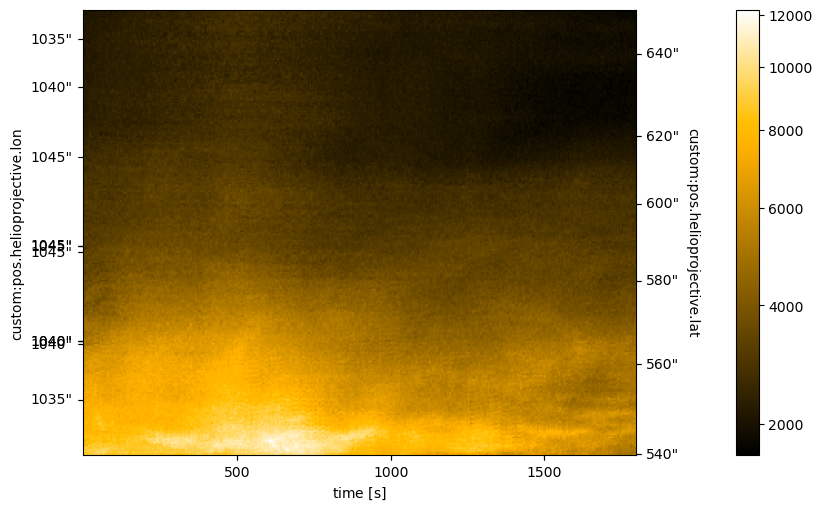

In [170]:
fig = plt.figure(figsize=(10,5),constrained_layout=True)

slit_3_spacetime_cube.plot(plot_axes=('x','y'),cmap='solar orbiterhri_euv174',norm=ImageNormalize(vmin=1500,stretch=AsinhStretch(0.4)))
plt.colorbar()

In [173]:
slit_3_pixels_0_3d = slit_3_pixels_0.make_3d()
slit_3_pixels_0_distance = []
for ii, pixel_ in enumerate(slit_3_pixels_0_3d):
    if ii == 0:
        slit_3_pixels_0_distance.append(0*u.m)
    else:
        slit_3_pixels_0_distance.append(pixel_.separation_3d(slit_3_pixels_0_3d[ii - 1]) + slit_3_pixels_0_distance[ii - 1])
slit_3_pixels_0_distance = u.Quantity(slit_3_pixels_0_distance)

In [176]:
slit_3_spacetime_distance_wcs = (QuantityTableCoordinate(slit_3_pixels_0_distance.to(u.Mm),
                                                physical_types="length",names="distance") &
                        TimeTableCoordinate(astropy.time.Time([map_.date for map_ in eui_map_seq_coalign]),
                                            physical_types="time",names="time")).wcs
slit_3_spacetime_distance_cube = NDCube(slit_3_intensity,slit_3_spacetime_distance_wcs)

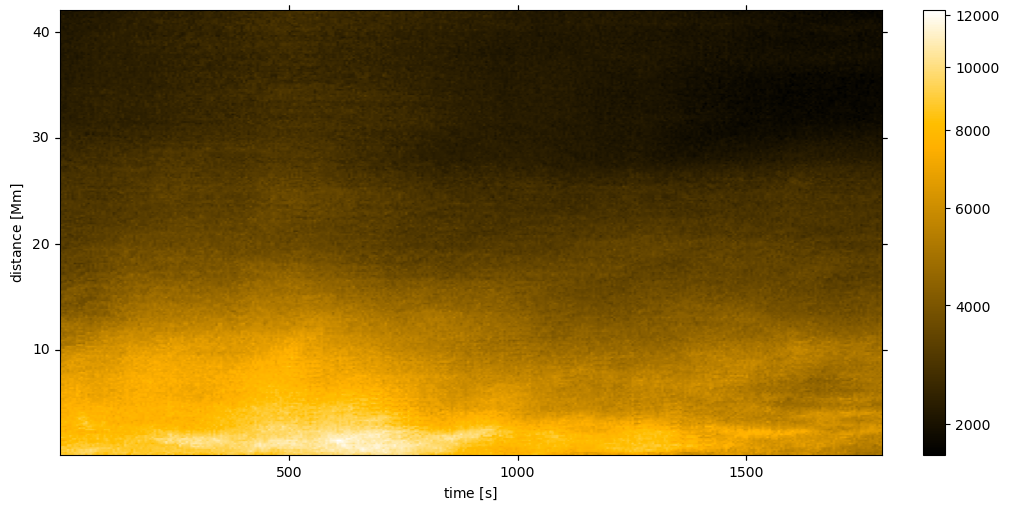

In [177]:
fig = plt.figure(figsize=(10,5),constrained_layout=True)
ax = fig.add_subplot(111,projection=slit_3_spacetime_distance_cube.wcs)
slit_3_spacetime_distance_cube.plot(axes = ax, plot_axes=('x','y'),cmap='solar orbiterhri_euv174',norm=ImageNormalize(vmin=1500,stretch=AsinhStretch(0.4)),
                                    aspect="auto")

plt.colorbar()